In [1]:
import pandas as pd 
import numpy as np 
import pylab as plt
import os
import time, enum
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import random

In [2]:
import networkx as nx
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, GeoJSONDataSource, ColorBar, HoverTool, Legend, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models.glyphs import Line
from bokeh.palettes import Category10, Viridis
output_notebook()

Loading BokehJS ...

In [3]:
os.chdir("/media/sid/Data/NFHS_Data/Data/ABM")

In [3]:
pwd

'/Genomics/grid/users/ckkumar/VaccinesAntibiotics'

In [6]:
if '__file__' not in globals():
    __file__ = '.'
    
fig_dir = os.path.abspath(os.path.join(os.path.dirname(__file__),"Figures"))
out_dir = os.path.abspath(os.path.join(os.path.dirname(__file__),"ResultFiles"))
data_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), "Data"))

In [7]:
birth_record = pd.read_csv(os.path.join(data_dir,'birth_record_edited.csv')) 
#birth_record = pd.read_csv('/media/sid/Data/NFHS_Data/Data/ABM/birth_record_edited.csv')

/Genomics/grid/users/ckkumar/.conda/envs/research_defaults/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (57) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
birth_record.head(10) #sample of file

,Unnamed: 0,caseid,bidx,v001,v002,v004,v024,v025,v026,v102,...,s191u,s190r,s191r,hep0,hep1,hep2,hep3,s515,s555,s558
0,1,01000101 02,1,10001,1,1,1,1,NaN,1,...,-47278.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,01000101 02,2,10001,1,1,1,1,NaN,1,...,-47278.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,01000101 02,3,10001,1,1,1,1,NaN,1,...,-47278.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,01000109 01,1,10001,9,1,1,1,NaN,1,...,-3057.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,01000109 01,2,10001,9,1,1,1,NaN,1,...,-3057.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,01000110 02,1,10001,10,1,1,1,NaN,1,...,26266.0,NaN,NaN,0.0,1.0,1.0,1.0,14.0,0.0,NaN
6,7,01000111 02,1,10001,11,1,1,1,NaN,1,...,10393.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,01000120 01,1,10001,20,1,1,1,NaN,1,...,29005.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,01000120 01,2,10001,20,1,1,1,NaN,1,...,29005.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,01000123 02,1,10001,23,1,1,1,NaN,1,...,30862.0,NaN,NaN,0.0,1.0,1.0,1.0,11.0,0.0,NaN


In [9]:
# subset of NFHS child data for AP state
#state attribute: v024
#code for AP:2
AP = birth_record[birth_record.v024 == 2]

In [10]:
#total number of cluster present in AP
culster = AP.groupby(['v001'])['v002'].count().reset_index()
len(culster[culster['v002']==1])
#>#clusters_AP-494
len(culster)

494

In [11]:
#>AP: 7991 HH in cluster 
len(AP['caseid'].unique()) #total household present in AP

7991

In [12]:
birth_record.head(30).sort_values(by= ["v001","v002"])
with pd.option_context('display.max_rows', 10, 'display.max_columns', None): 
    display(birth_record.head(30).sort_values(by= ["v001","v002"]))

,Unnamed: 0,caseid,bidx,v001,v002,v004,v024,v025,v026,v102,v106,v113,v116,v120,v121,v122,v123,v124,v125,v130,v131,v136,v137,v151,v152,v160,v161,v190,v191,v201,v206,v207,v208,v218,v445,v446,v462,v463a,v463b,v463c,v463d,v463e,v463f,v463g,v463x,v481,v729,v730,v732,b4,b8,h1,h2,h3,h4,h5,h6,h7,h8,h9,h0,h10,h11,h15,h15b,h15g,h15i,h22,h31b,h31c,h37i,h37j,h37y,h37z,sdistri,sslumc,sslumo,s116,s707,s716,s723a,s723b,s723c,s723d,s723e,s190u,s191u,s190r,s191r,hep0,hep1,hep2,hep3,s515,s555,s558
0,1,01000101 02,1,10001,1,1,1,1,NaN,1,0,11,12,0,1,1,0,0,0,3,991.0,4,0,1,51,0.0,2,3,37639.0,3,0,0,0,3,2295.0,1494.0,NaN,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,2,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,640.0,NaN,NaN,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-47278.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,01000101 02,2,10001,1,1,1,1,NaN,1,0,11,12,0,1,1,0,0,0,3,991.0,4,0,1,51,0.0,2,3,37639.0,3,0,0,0,3,2295.0,1494.0,NaN,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,1,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,640.0,NaN,NaN,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-47278.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,01000101 02,3,10001,1,1,1,1,NaN,1,0,11,12,0,1,1,0,0,0,3,991.0,4,0,1,51,0.0,2,3,37639.0,3,0,0,0,3,2295.0,1494.0,NaN,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,2,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,640.0,NaN,NaN,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-47278.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,01000109 01,1,10001,9,1,1,1,NaN,1,1,12,12,0,1,1,0,0,0,1,993.0,3,0,2,40,0.0,2,4,74391.0,2,0,0,0,2,2611.0,1754.0,NaN,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,2,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,640.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,-3057.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,01000109 01,2,10001,9,1,1,1,NaN,1,1,12,12,0,1,1,0,0,0,1,993.0,3,0,2,40,0.0,2,4,74391.0,2,0,0,0,2,2611.0,1754.0,NaN,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,2,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,640.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,-3057.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,26,01000157 02,2,10001,57,1,1,1,NaN,1,2,12,12,0,1,1,0,0,0,3,993.0,3,0,1,41,0.0,2,5,117034.0,2,0,0,0,2,2515.0,1610.0,NaN,0,0,0,0,0,0,1,0,0,2.0,41.0,NaN,1,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,640.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,48253.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,27,01000162 02,1,10001,62,1,1,1,NaN,1,2,11,12,0,1,1,0,1,0,1,991.0,4,0,1,54,0.0,2,5,114868.0,2,0,0,0,2,2720.0,1765.0,NaN,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,2,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,640.0,NaN,NaN,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,45646.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,28,01000162 02,2,10001,62,1,1,1,NaN,1,2,11,12,0,1,1,0,1,0,1,991.0,4,0,1,54,0.0,2,5,114868.0,2,0,0,0,2,2720.0,1765.0,NaN,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,2,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,640.0,NaN,NaN,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,45646.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,29,01000171 02,1,10001,71,1,1,1,NaN,1,3,11,12,0,1,1,0,1,0,1,993.0,2,0,1,46,0.0,2,5,140491.0,2,0,0,0,2,3152.0,2180.0,NaN,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,640.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,76477.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Model Starts here..

In [13]:
#> MESA framework create two classes. One for the agents and one for the model
#> The agent handles the behaviour of the individual(children) being simulated via model
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    #exposed
    #recovered
    #treated
    REMOVED = 2

In [14]:
State.INFECTED

<State.INFECTED: 1>

# ...

In [15]:
# creating a model for only one state as a prototype

In [16]:
#currently this listing is till age 27 only because max age of a child is 27 for AP
#> Our target 0-5
#> These are infectting their siblings. Siblings> 5yr. they spread.
age_groups_contacts = {'0-1':[0,1], '1-2':[2],'2-3':[3],'3-4':[4],'4-5':[5],'5-6':[6],'6-7':[7],'7-8':[8],'8-9':[9],'9-10':[10],
                       '10-11':[11],'11-12':[12],'12-13':[13],'13-14':[14],'14-15':[15],'15-16':[16],
                       '16-17':[17],'17-18':[18],'18-19':[19],'19-20':[20],
                       '20-21':[21],'21-22':[22],'22-23':[23],'23-24':[24],'24-25':[25],'25-26':[26],'26-27':[27]}

In [17]:
# this returns the key value from the above dict from the contact matrix
def get_key(val):
    for key, value in age_groups_contacts.items():
        if val in value:
            return key

In [18]:
#Three contact matri used: household contact matrix, Community matrix and School
contacts_hh = pd.read_csv(os.path.join(data_dir, 'contact_matrics_AP_household.csv'),index_col=None) 
#contacts_hh = pd.read_csv(os.path.join(data_dir, '/media/sid/Data/NFHS_Data/Data/ABM/contact_matrics_AP_household.csv'),index_col=None) 
contacts_hh.index = ['0-1','1-2','2-3','3-4','4-5','5-6','6-7','7-8','8-9','9-10',
                     '10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20',
                     '20-21','21-22','22-23','23-24','24-25','25-26','26-27','27-28','28-29','29-30',
                     '30-31','31-32','32-33','33-34','34-35','35-36','36-37','37-38','38-39','39-40',
                     '40-41','41-42','42-43','43-44','44-45','45-46','46-47','47-48','48-49','49-50',
                     '50-51','51-52','52-53','53-54','54-55','55-56','56-57','57-58','58-59','59-60',
                     '60-61','61-62','62-63','63-64','64-65','65-66','66-67','67-68','68-69','69-70',
                     '70-71','71-72','72-73','73-74','74-75','75-76','76-77','77-78','78-79','79-80',
                     '80-81','81-82','82-83','83-84','85+'
                   ]

contacts_hh.columns = ['0-1','1-2','2-3','3-4','4-5','5-6','6-7','7-8','8-9','9-10',
                      '10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20',
                      '20-21','21-22','22-23','23-24','24-25','25-26','26-27','27-28','28-29','29-30',
                      '30-31','31-32','32-33','33-34','34-35','35-36','36-37','37-38','38-39','39-40',
                      '40-41','41-42','42-43','43-44','44-45','45-46','46-47','47-48','48-49','49-50',
                      '50-51','51-52','52-53','53-54','54-55','55-56','56-57','57-58','58-59','59-60',
                      '60-61','61-62','62-63','63-64','64-65','65-66','66-67','67-68','68-69','69-70',
                      '70-71','71-72','72-73','73-74','74-75','75-76','76-77','77-78','78-79','79-80',
                      '80-81','81-82','82-83','83-84','85+'
                    ]

In [19]:
contacts_hh.index

Index(['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10',
       '10-11', '11-12', '12-13', '13-14', '14-15', '15-16', '16-17', '17-18',
       '18-19', '19-20', '20-21', '21-22', '22-23', '23-24', '24-25', '25-26',
       '26-27', '27-28', '28-29', '29-30', '30-31', '31-32', '32-33', '33-34',
       '34-35', '35-36', '36-37', '37-38', '38-39', '39-40', '40-41', '41-42',
       '42-43', '43-44', '44-45', '45-46', '46-47', '47-48', '48-49', '49-50',
       '50-51', '51-52', '52-53', '53-54', '54-55', '55-56', '56-57', '57-58',
       '58-59', '59-60', '60-61', '61-62', '62-63', '63-64', '64-65', '65-66',
       '66-67', '67-68', '68-69', '69-70', '70-71', '71-72', '72-73', '73-74',
       '74-75', '75-76', '76-77', '77-78', '78-79', '79-80', '80-81', '81-82',
       '82-83', '83-84', '85+'],
      dtype='object')

In [20]:
contacts_hh

,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10,...,75-76,76-77,77-78,78-79,79-80,80-81,81-82,82-83,83-84,85+
0-1,0.023917,0.023024,0.026281,0.023106,0.021041,0.021982,0.019811,0.020316,0.017784,0.015987,...,0.000626,0.000683,0.000468,0.000819,0.000487,0.000518,0.000382,0.000334,0.000132,0.000484
1-2,0.023885,0.022874,0.025814,0.023242,0.020986,0.022262,0.019583,0.019259,0.017480,0.015761,...,0.000604,0.000610,0.000614,0.000497,0.000558,0.000475,0.000299,0.000262,0.000145,0.000661
2-3,0.022841,0.021627,0.026663,0.022630,0.021639,0.022210,0.019794,0.021397,0.019629,0.017161,...,0.000689,0.000674,0.000484,0.000695,0.000394,0.000384,0.000428,0.000342,0.000201,0.000778
3-4,0.020803,0.020172,0.023443,0.022830,0.021046,0.022386,0.020371,0.022745,0.021552,0.017885,...,0.000534,0.000607,0.000445,0.000666,0.000502,0.000366,0.000318,0.000270,0.000223,0.000790
4-5,0.018755,0.018032,0.022193,0.020836,0.020251,0.020477,0.019025,0.021384,0.020086,0.017993,...,0.000717,0.000726,0.000497,0.000672,0.000561,0.000511,0.000383,0.000339,0.000146,0.000967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80-81,0.006466,0.005720,0.005516,0.005074,0.007159,0.007162,0.006962,0.008139,0.007555,0.008187,...,0.008954,0.006733,0.006773,0.006095,0.008483,0.005859,0.003407,0.006000,0.002448,0.012162
81-82,0.006135,0.004634,0.007914,0.005675,0.006907,0.007190,0.006359,0.008987,0.007898,0.007862,...,0.010269,0.008051,0.008100,0.008547,0.003616,0.004390,0.005772,0.006291,0.002443,0.015555
82-83,0.005563,0.004207,0.006555,0.005004,0.006347,0.007088,0.007161,0.007791,0.007075,0.007393,...,0.017764,0.012831,0.010308,0.012025,0.007117,0.008019,0.006525,0.005568,0.000960,0.011135
83-84,0.003500,0.003702,0.006146,0.006583,0.004356,0.008746,0.007161,0.006882,0.007202,0.009130,...,0.014639,0.007440,0.007934,0.007116,0.006913,0.005209,0.004035,0.001529,0.000000,0.011150


In [21]:
contacts_hh.columns 

Index(['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10',
       '10-11', '11-12', '12-13', '13-14', '14-15', '15-16', '16-17', '17-18',
       '18-19', '19-20', '20-21', '21-22', '22-23', '23-24', '24-25', '25-26',
       '26-27', '27-28', '28-29', '29-30', '30-31', '31-32', '32-33', '33-34',
       '34-35', '35-36', '36-37', '37-38', '38-39', '39-40', '40-41', '41-42',
       '42-43', '43-44', '44-45', '45-46', '46-47', '47-48', '48-49', '49-50',
       '50-51', '51-52', '52-53', '53-54', '54-55', '55-56', '56-57', '57-58',
       '58-59', '59-60', '60-61', '61-62', '62-63', '63-64', '64-65', '65-66',
       '66-67', '67-68', '68-69', '69-70', '70-71', '71-72', '72-73', '73-74',
       '74-75', '75-76', '76-77', '77-78', '78-79', '79-80', '80-81', '81-82',
       '82-83', '83-84', '85+'],
      dtype='object')

In [22]:
#check error in path?
#contacts_comm = pd.read_csv(os.path.join(data_dir, '/media/sid/Data/NFHS_Data/Data/ABM/contact_matrics_AP_community.csv'),index_col=None) 
contacts_comm = pd.read_csv(os.path.join(data_dir, 'contact_matrics_AP_community.csv'),index_col=None) 
contacts_comm.index = ['0-1','1-2','2-3','3-4','4-5','5-6','6-7','7-8','8-9','9-10',
                 '10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20',
                 '20-21','21-22','22-23','23-24','24-25','25-26','26-27','27-28','28-29','29-30',
                 '30-31','31-32','32-33','33-34','34-35','35-36','36-37','37-38','38-39','39-40',
                 '40-41','41-42','42-43','43-44','44-45','45-46','46-47','47-48','48-49','49-50',
                 '50-51','51-52','52-53','53-54','54-55','55-56','56-57','57-58','58-59','59-60',
                 '60-61','61-62','62-63','63-64','64-65','65-66','66-67','67-68','68-69','69-70',
                 '70-71','71-72','72-73','73-74','74-75','75-76','76-77','77-78','78-79','79-80',
                 '80-81','81-82','82-83','83-84','85+'
                ]

contacts_comm.columns = ['0-1','1-2','2-3','3-4','4-5','5-6','6-7','7-8','8-9','9-10',
                '10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20',
                 '20-21','21-22','22-23','23-24','24-25','25-26','26-27','27-28','28-29','29-30',
                 '30-31','31-32','32-33','33-34','34-35','35-36','36-37','37-38','38-39','39-40',
                 '40-41','41-42','42-43','43-44','44-45','45-46','46-47','47-48','48-49','49-50',
                 '50-51','51-52','52-53','53-54','54-55','55-56','56-57','57-58','58-59','59-60',
                 '60-61','61-62','62-63','63-64','64-65','65-66','66-67','67-68','68-69','69-70',
                 '70-71','71-72','72-73','73-74','74-75','75-76','76-77','77-78','78-79','79-80',
                 '80-81','81-82','82-83','83-84','85+'
                ]

In [23]:
#> Missing school level Matrix added. 85row/Col.
#contacts_school = pd.read_csv(os.path.join(data_dir,'/media/sid/Data/NFHS_Data/Data/ABM/contact_matrics_AP_community.csv')) #School level contact matrix
#contacts_school.index = ['0-1','1-2','2-3','3-4','4-5','5-6','6-7','7-8','8-9','9-10',
#                 '10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20',
#                 '20-21','21-22','22-23','23-24','24-25','25-26','26-27','27-28','28-29','29-30',
#                 '30-31','31-32','32-33','33-34','34-35','35-36','36-37','37-38','38-39','39-40',
#                 '40-41','41-42','42-43','43-44','44-45','45-46','46-47','47-48','48-49','49-50',
#                 '50-51','51-52','52-53','53-54','54-55','55-56','56-57','57-58','58-59','59-60',
#                 '60-61','61-62','62-63','63-64','64-65','65-66','66-67','67-68','68-69','69-70',
#                 '70-71','71-72','72-73','73-74','74-75','75-76','76-77','77-78','78-79','79-80',
#                 '80-81','81-82','82-83','83-84','85+'
#                ]

#contacts_school.columns = ['0-1','1-2','2-3','3-4','4-5','5-6','6-7','7-8','8-9','9-10',
#                 '10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20',
#                 '20-21','21-22','22-23','23-24','24-25','25-26','26-27','27-28','28-29','29-30',
#                 '30-31','31-32','32-33','33-34','34-35','35-36','36-37','37-38','38-39','39-40',
#                 '40-41','41-42','42-43','43-44','44-45','45-46','46-47','47-48','48-49','49-50',
#                 '50-51','51-52','52-53','53-54','54-55','55-56','56-57','57-58','58-59','59-60',
#                 '60-61','61-62','62-63','63-64','64-65','65-66','66-67','67-68','68-69','69-70',
#                 '70-71','71-72','72-73','73-74','74-75','75-76','76-77','77-78','78-79','79-80',
#                 '80-81','81-82','82-83','83-84','85+'

In [25]:
#> Mesa builds two main classes; child(Agent), NetworkInfectionModel(Model) 
class Child(Agent): 
    """An agent with fixed initial values."""
    def __init__(self, unique_id, node, model):
        super().__init__(unique_id, model)
        self.id = node
        if self.model.G.nodes[node]['age'] <= 5: # TODO: it looks to me like we're just taking the first 5000
            # entries and using those in our model
            # we need to randomly draw ages, genders, household attributes, etc. from the data
            # for an explanation of how to do this, see the COVID ABM
            # the idea is that the 5000 agents we simulate should be a random sampling of the entire dataset
            # and beyond that, if we ran with 5000 different agents, we would get different individual agents
            # although at the population level we should have the same attributes
        #children under 5 years of age    
            self.agent_type = 1 
        else:
            self.agent_type = 2
        
        self.state = State.SUSCEPTIBLE        
        self.infection_time = 0     
        
        # TODO: need to flesh out this init section to include many features that make the agents specific
        # in particular, as we've discussed, each agent should have their own value of incubation period, infectivity rate, etc.
        # with values drawn from the distribution
       
    def move(self):
        """Move the child agent"""
        
        possible_steps = self.model.grid.get_neighbors(self.id,include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
    def status(self): 
        """Check for the infection status"""
        
        if self.state == State.INFECTED:     
            drate = self.model.death_rate
            alive = np.random.choice([0,1], p=[drate,1-drate]) # can just do if np.random.uniform(0, 1) <= drate:
            if alive == 0:
                self.model.schedule.remove(self)            # how does this handle alive == 1? -- need to add in going forward
            t = self.model.schedule.time-self.infection_time # this is a clever way of handling this! more efficient than holding a time variable for every agent
            if t >= self.recovery_time:          
                self.state = State.REMOVED

    def contact(self):
        """Find close contacts and infect"""
        
        # there may be a more efficient way of doing this that doesn't require querying the grid
        # since we are using the assumption that all children are connected, iterate through all children on
        # the grid and first ask if they are susceptble, then ask if they get infected using the probability
        # of transmission and drawing random numbers like below....
        
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False) # for the future, i don't agree with include_center=False -- a child can infect their siblings -- this depends on whether you have siblings on separate nodes or not
        #print(neighbors_nodes)
        susceptible_neighbors = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
            if agent.state is State.SUSCEPTIBLE
        ]
        #print('sus')
        
        # if we use a probability of transmission, this is the right implementation
        # however, note that we may use an alternative implementation where we calculate a pseudo number of
        # people infected by day based on the probability of transmission over time and individual R0
        # for details on how this is practically implemented, see the COVID ABM
        # the key idea here is that going in, we know how many individuals an agent will infect on a daily basis
        # then, we just need to figure out who they are going to infect
        # that's why we use the contact matrix to figure out who is most likely to be infected
        
        for a in susceptible_neighbors:
            
            # TODO: remember that here we need to use the contact matrix value as a weight and not a probability
            # so in reality you take the probability of transmission and you multiply it by weight_node / weight_avg
            # we can talk more about this when we have our call
            
            if (self.random.random()) < (self.model.ptrans)*(self.model.G.edges[self.id,a.id,0]['weight']): #probability of transmission
            #if self.random.random() < self.model.ptrans: #probability of transmission
                print('infected')
                a.state = State.INFECTED
                a.recovery_time = a.model.get_recovery_time()
        #print('contact')
        
    def step(self):
        #print('agent step')
        self.status()
        self.move()
        self.contact()
        #self.interact()

        # looks good!
        # eventually we will also add things like self.treatment() and self.vaccinate() and functions along those lines
        
    def toJSON(self):        
        d = self.id
        return json.dumps(d, default=lambda o: o.__dict__, sort_keys=True, indent=4)

In [27]:
#> NW of 0-5 Y children w/ sibling and other chidren of cluster
#> NW on which we wil spread the infection

G = nx.MultiDiGraph()
#creating the network of siblings
arr = AP['caseid'][AP['b8']<=5].unique() #'arr' unique household IDs where age of any children is less than 5 years
household = arr.tolist() #household IDs to list
filtered = AP[AP['caseid'].isin(household)] #flitered for under 5 years of age and their siblings. All kinds in th 0-5y HH
filtered['unique_id'] = (filtered['caseid']+ filtered['bidx'].apply(str)) #creating another unique ID for every individual

f = filtered.groupby(['v001'])['caseid'].count().reset_index() #count of households in each cluster
ff = f[f['caseid']<=1] 
remove_cluster_list1= list(ff['v001'])#creating the list of the cluster

filtered = filtered[~filtered['v001'].isin(remove_cluster_list1)] # removing all the cluster with 1 household
filtered = filtered[filtered['b8'].notna()] #removing all the 

ID = list(filtered['unique_id'])

<ipython-input-27-5210871a6dc1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['unique_id'] = (filtered['caseid']+ filtered['bidx'].apply(str)) #creating another unique ID for every individual


In [28]:
#> Contents of the model: general parameters, a grid object(for moving agents), variable to track teh agents
#>  class "NetworkInfectionModel";  defines network grid using networkX. 
#Timeperiods are represented as steps where all agents move in onestep. 
#> "Datacollector" class keeps track of agent information through steps
#> The "grid" is a MultiGrid class, which let more than one agent occupy a cell at once.

class NetworkInfectionModel(Model):
    """A model for infection spread."""
    #ptrans:probability of transmission
#> Where to get this data?
#> N: number of agents,   
#> redundant: Deg. of Sep #N=10

    def __init__(self, ptrans=0.8,progression_period=3, progression_sd=2, death_rate=0.0193, recovery_days=14,
                 recovery_sd=7, ID = ID):
        
#>> Numbers to be fed ?       
        self.initial_outbreak_size = 1
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd
        self.ptrans = ptrans
        self.death_rate = death_rate
#>> MultiDg. created . ID from above comes and its created. It comes alogn with the above data     
        #creating the network of children
        self.G = nx.MultiDiGraph()
        self.G.add_nodes_from(ID)
        self.grid = NetworkGrid(self.G)

        self.schedule = RandomActivation(self)
        self.running = True
        
        #adding attributes to each node (each node is a child)
        
#>Empty dict. Only agents in
        self.attrs = {}
        for i in range(len(list(self.G.nodes))):
            self.attrs[list(self.G.nodes)[i]] = {"h_ID": filtered.loc[filtered['unique_id'] == list(self.G.nodes)[i], 'v002'].item(),
                        "cluster_ID": filtered.loc[filtered['unique_id'] == list(self.G.nodes)[i], 'v001'].item(),
                        "age":filtered.loc[filtered['unique_id'] == list(self.G.nodes)[i], 'b8'].item(),
                        "sex":filtered.loc[filtered['unique_id'] == list(self.G.nodes)[i], 'b4'].item(),
                        "res_type":filtered.loc[filtered['unique_id'] == list(self.G.nodes)[i], 'v025'].item(),
                        "highest_edu":filtered.loc[filtered['unique_id'] == list(self.G.nodes)[i], 'v106'].item(),
                        "wealth_index":filtered.loc[filtered['unique_id'] == list(self.G.nodes)[i], 'v190'].item(),
                        "hh_head_sex":filtered.loc[filtered['unique_id'] == list(self.G.nodes)[i], 'v151'].item()
                         }
        nx.set_node_attributes(self.G, self.attrs)
        
        self.clust_list = list(set(list(nx.get_node_attributes(self.G,'cluster_ID').values())))
        #looping cluster then nodes in those cluster
        for cluster in self.clust_list:
            self.selected_nodes = [n for n,v in self.G.nodes(data=True) if v['cluster_ID'] == cluster]  
            for a in self.selected_nodes:
                for b in self.selected_nodes:
                    if a==b: # can cut out this if statement...
                        pass
                    # this looks great!
                    elif (self.G.nodes[a]['h_ID'] == self.G.nodes[b]['h_ID']):
                        self.contact_prob = contacts_hh[get_key(self.G.nodes[a]['age'])][get_key(self.G.nodes[b]['age'])]
                        self.G.add_edge(a,b, weight = self.contact_prob)
                    else:
                        self.contact_prob = contacts_comm[get_key(self.G.nodes[a]['age'])][get_key(self.G.nodes[b]['age'])]
                        self.G.add_edge(a,b, weight=self.contact_prob)

        # Create agents
        for i, node in enumerate(self.G.nodes()):
            a = Child(i+1, node, self)
            self.schedule.add(a)
            #add agent
            self.grid.place_agent(a, node)

            #make some agents infected at start
            infected = np.random.choice([0,1], p=[0.99,0.01])
            if infected == 1:
                a.state = State.INFECTED
                a.recovery_time = self.get_recovery_time()

        self.datacollector = DataCollector(agent_reporters={"State": "state"})
        
    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        #print('model step')

In [29]:
#running the model
model = NetworkInfectionModel()
for i in range(30):
    print(i)
    model.step()

0
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected

infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
i

infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
i

infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
11
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infecte

infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
25
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
26
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
27
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
28
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infecte

In [30]:
#> View model states data.
#>convert data to into wide form.reason, ease of plotting
#> The DataCollector object holds agent variables.can be analysed to get model results
#> get_agent_vars_dataframe() returns a pandas DataFrame in long form of the state of each agent at each step
def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Infected','Removed']
    X.columns = labels[:len(X.columns)]
    return X
    
def plot_states(model,ax):    
    steps = model.schedule.steps
    X = get_column_data(model)
    X.plot(ax=ax,lw=3,alpha=0.8)
    return f

In [31]:
steps=50
st=time.time()
model = NetworkInfectionModel(ptrans=0.5)
for i in range(steps):
    model.step()
print (time.time()-st)
agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:10])

infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
i

infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
i

infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
i

infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
i

infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
i

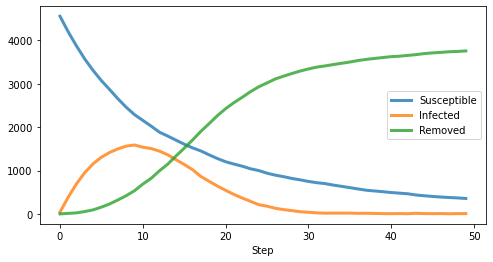

In [32]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SIR.png',dpi=150)

infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
infected
i

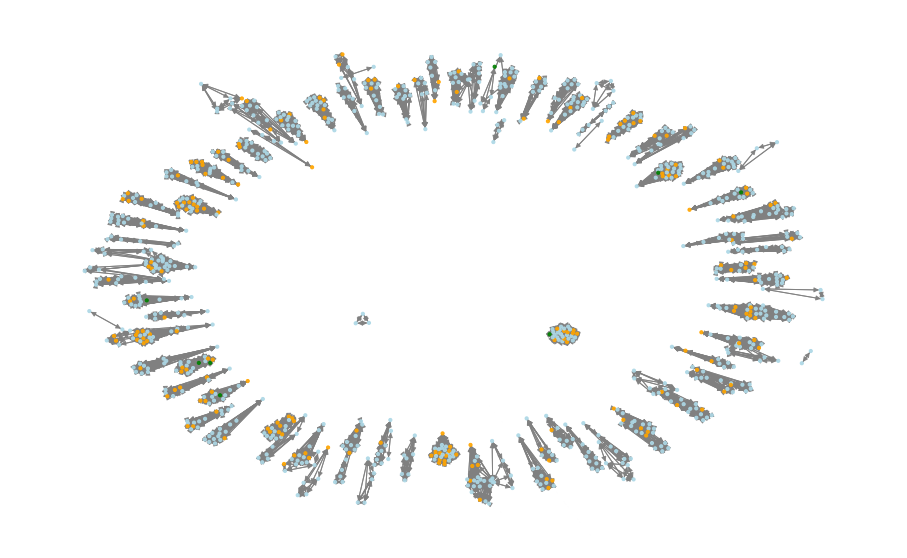

In [33]:
cmap = ListedColormap(["lightblue", "orange", "green",])

def plot_grid(model,fig,layout='spring',title=''):
    graph = model.G
    #if layout == 'kamada-kawai':      
    pos = nx.spring_layout(graph)  
    #elif layout == 'circular':
        #pos = nx.circular_layout(graph)
    #else:
        #pos = nx.spring_layout(graph, iterations=5, seed=8)  
    plt.clf()
    ax=fig.add_subplot()
    states = [int(i.state) for i in model.grid.get_all_cell_contents()]

    #cells = [(i.pos,int(i.state)) for i in model.grid.get_all_cell_contents()]
    #print (cells[:10])
    #print (pos)
    #print (pd.Series(states).value_counts())
    colors = [cmap(i) for i in states]
    
    nx.draw(graph, pos, node_size=10, edge_color='gray', node_color=colors, #with_labels=True,
            alpha=0.9,font_size=7,ax=ax)
    #print (ax.patches)
    #ax.legend(['S','I','R'])
    ax.set_title(title)
    return

fig,ax=plt.subplots(1,1,figsize=(16,10))
model = NetworkInfectionModel(ptrans=0.6, ID=ID[1:1000])
model.step();model.step()
f=plot_grid(model,fig,layout='kamada-kawai')
plt.savefig('abm_networkgrid.jpg')

In [34]:
def run_model(steps, delay, layout):

    model = NetworkInfectionModel()
    
    #fig,ax=plt.subplots(1,1,figsize=(10,8))
    fig1 = plt.Figure(figsize=(8,6))
    #ax1=fig1.add_subplot(1,1,1,label='a')
    grid_pane.object = fig1
    fig2 = plt.Figure(figsize=(8,6))
    ax2=fig2.add_subplot(1,1,1,label='b')
    states_pane.object = fig2 

    for i in range(steps):
        model.step()
        plot_grid(model,fig1,title='step=%s' %i, layout=layout)        
        grid_pane.param.trigger('object')
        ax2.clear()
        plot_states(model,ax2)
        ax2.set_xlim(0,steps)
        #states_pane.object = fig2
        states_pane.param.trigger('object')    
        time.sleep(delay)
    plt.clf()
    
#run_model(50, 20, 1, 20, 1)